<a href="https://colab.research.google.com/github/SoundaryaDube/ECG_Analysis/blob/main/ECG_Analysis_of_MIT_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb biosppy scikit-learn matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 998.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

# Define the dataset paths as strings within a list
dataset_paths = [
    "/content/drive/MyDrive/Datasets/mit-bih-arrhythmia-database-1.0.0.zip",
    "/content/drive/MyDrive/Datasets/mit-bih-supraventricular-arrhythmia-database-1.0.0.zip"
]
extract_path = "/content/ECG_Data/"

# Iterate over the dataset paths and extract each zip file
for dataset_path in dataset_paths:
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:  # dataset_path is now a string
        zip_ref.extractall(extract_path)

print("All ECG datasets extracted successfully!")

All ECG datasets extracted successfully!


In [ ]:
record = wfdb.rdrecord('100', pn_dir='mitdb')  # Load full record

In [ ]:
record_ids = ['100', '101', '102', '103']
all_features = []

for rid in record_ids:
    record = wfdb.rdrecord(rid, sampto=10000, pn_dir='mitdb')
    signal = record.p_signal[:,0]
    feats = extract_features(signal)
    all_features.append(feats)

features = np.vstack(all_features)
print("Total features:", features.shape)

Total features: (122, 4)


In [ ]:
def extract_features(signal, fs=360):
    peaks, _ = find_peaks(signal, distance=fs*0.6)  # approximate R peaks every 0.6s
    rr_intervals = np.diff(peaks) / fs

    features = []
    for i in range(1, len(rr_intervals)-1):
        rr_current = rr_intervals[i]
        rr_prev = rr_intervals[i-1]
        rr_next = rr_intervals[i+1]
        qrs_width = (peaks[i+1] - peaks[i-1]) / fs

        features.append([rr_current, rr_prev, rr_next, qrs_width])
    return np.array(features)

features = extract_features(signal)
print("Extracted features shape:", features.shape)

Extracted features shape: (30, 4)


In [ ]:
labels = np.zeros(features.shape[0])
labels[::10] = 1  # Simulated arrhythmia label every 10 beats

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.25, stratify=labels, random_state=42)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Accuracy: 0.875
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      1.00      0.93         7
         1.0       0.00      0.00      0.00         1

    accuracy                           0.88         8
   macro avg       0.44      0.50      0.47         8
weighted avg       0.77      0.88      0.82         8



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


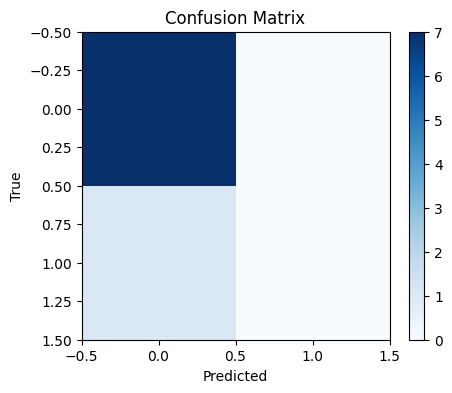

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(conf_mat, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()